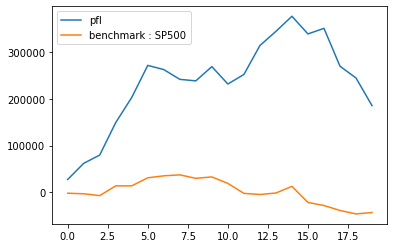

In [1]:
from hw1 import *
#from tool_func import *
import yfinance as yf
import statsmodels.api as sm

def factor_ror(factor_df,ror_df,chg_period_int = 20)->pd.DataFrame():
    factor_df.dropna(axis=0, inplace=True, how='all')
    #20 days accumulate ror
    ror_accu_df = np.log(ror_df+1)
    ror_accu_df = np.exp(ror_accu_df.rolling(chg_period_int,axis=0).sum())-1
    ror_shift_df = ror_accu_df.shift(-chg_period_int).dropna(axis=0)
    idx_intersect_list = np.intersect1d(factor_df.index.tolist(),ror_shift_df.index.tolist()).tolist()
    ror_shift_df = ror_shift_df.reindex(idx_intersect_list, axis=0)
    factor_df = factor_df.reindex(idx_intersect_list,axis=0)
    real_dt_idx = [i+dt.timedelta(chg_period_int) for i in idx_intersect_list]
    #reg for factor ret
    factor_ret_list = []
    for i in range(factor_df.shape[0]):
        X_array = factor_df.iloc[i,:].values
        y_array = ror_shift_df.iloc[i,:].values
        # nan detect
        nan_locX_array = np.where(np.isnan(X_array)==True)
        nan_locy_array = np.where(np.isnan(y_array)==True)
        nan_loc_array = np.union1d(nan_locy_array,nan_locX_array)
        X_array = np.delete(X_array,nan_loc_array)
        y_array = np.delete(y_array,nan_loc_array)
        #add constant
        X_array = sm.add_constant(X_array)
        model = sm.OLS(y_array,X_array)
        result = model.fit()
        coef_float = result.params[1]
        factor_ret_list.append(coef_float)
    factor_ror_df = pd.DataFrame(factor_ret_list,index=real_dt_idx)
    return factor_ror_df

def momentum_factor(ror_df,window_int):
    ror_df = np.log(ror_df+1)
    momentum_factor_df = np.exp(ror_df.rolling(window_int,axis=0).sum())-1
    return momentum_factor_df

def cal_beta(stk_ror_array,bmk_ror_array)->float:
    X_array = sm.add_constant((bmk_ror_array - ror_10_treasure_float).reshape(-1, 1))
    y_array = (stk_ror_array - ror_10_treasure_float).reshape(-1, 1)
    model = sm.OLS(y_array, X_array)
    result = model.fit()
    beta_float = result.params[1]
    return beta_float

def cal_multibeta(stk_ror_array,factor_ror_list)->float:
    ror_array = np.concatenate(factor_ror_list,axis=1)
    X_array = sm.add_constant(ror_array - ror_10_treasure_float)
    y_array = (stk_ror_array - ror_10_treasure_float).reshape(-1, 1)
    model = sm.OLS(y_array, X_array)
    result = model.fit()
    beta_array = result.params[1:]
    return beta_array

(A)

portfolio beta: 1.8263967523391593


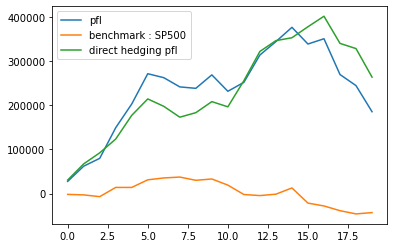

In [2]:
#portfolio beta
beta_pfl_float = cal_beta(pfl_d_ret_cmb_array,bmk_d_ret_array)
print(f'portfolio beta: {beta_pfl_float}')
dr_hedged_pfl_ret_array = pfl_d_ret_cmb_array-bmk_d_ret_array*beta_pfl_float
partial_sum_dr_hedged_pfl_ret_array = np.add.accumulate(dr_hedged_pfl_ret_array)
#plotting
plt.plot(np.sum(partial_sum_pfl_ret_array,axis=1),label='pfl')
plt.plot(partial_sum_bmk_ret_array,label='benchmark : SP500')
plt.plot(partial_sum_dr_hedged_pfl_ret_array,label='direct hedging pfl')
plt.legend()
plt.show()

According to CAPM, if we try to hedge $r_m$ in the portfolio, we can calculate the $\beta_m$ of portfolio relative to our
benchmark: SP500. $\beta_m$ means the if the market's ror change by 1% then portfolio's ror should change $\beta_m$*1%.
so if we short $\beta_m$ * SPY in portfolio, we can rule out market's effect over the portfolio.

In [3]:
# download data
try:
    adj_close_hedging_df = pd.read_csv(r'E:\study\22fall\hf\data\hw2\hedged_close.csv',index_col=0)
except:
    #sp500 components
    hedging_list = ['TSLA','CVX']
    adj_close_hedging_df = yf.download(tickers=hedging_list,start = '2021-08-09',end = '2022-09-17')
    adj_close_hedging_df = adj_close_hedging_df.iloc[:,:2]
    adj_close_hedging_df.columns = [i[1] for i in adj_close_hedging_df.columns]
    adj_close_hedging_df.to_csv(r'E:\study\22fall\hf\data\hw2\hedged_close.csv')

(B)

To hedge a stock with another stock, we need to short the hedging stock with $\frac{\beta1}{\beta2}$ share for each share of hedged stock.
I think a satifying hedging stock should have similar beta which can reduce the loss due to non-integer hedging coefficient
$\frac{\beta1}{\beta2}$. Another worry of implicit hedging is that the hedging stock may pose its idiosyncratic effects over the hedging porfolio.

Thereofore, I think we should choose stocks with similar backgrounds, like industry, to reduce such side effects.
Follow above disciplines, I chose CVX,which shares similar beta(1.14) with XOM(1.07) and is also in oid&gas industry.
For ALB, a Lithium producer, since it is strongly related to ev producer, like TSLA. Though these two companies have very different
beta, I still chose TSLA due to its strong connection with Lithium.

(C)

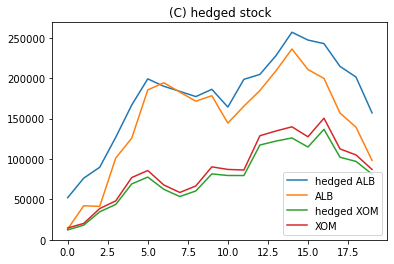

In [4]:
#cal ror
hedging_ror_df = adj_close_hedging_df/adj_close_hedging_df.shift(1)-1
#alter index format
hedging_ror_df.index = pd.to_datetime(hedging_ror_df.index)
ror_df = pd.merge(ror_df,hedging_ror_df,left_index=True,right_index=True,how='left')
ror_array = ror_df.iloc[beg_loc_int+1:end_loc_int+1,:].values
#cal beta
beta_hd1_float = cal_beta(ror_array[:,0].reshape(-1,1),ror_array[:,2].reshape(-1,1)) #ALB beta
beta_hd2_float = cal_beta(ror_array[:,1].reshape(-1,1),ror_array[:,2].reshape(-1,1)) #XOM beta
beta_h1_float = cal_beta(ror_array[:,4].reshape(-1,1),ror_array[:,2].reshape(-1,1))#TSLA beta
beta_h2_float = cal_beta(ror_array[:,3].reshape(-1,1),ror_array[:,2].reshape(-1,1))#CVX beta
#hedging stk daily return, apply same weights as hedged 2 stocks
h1_ret_array = cash_init_float/2*ror_array[:,4].reshape(-1,1)
h2_ret_array = cash_init_float/2*ror_array[:,3].reshape(-1,1)
#hedging pfl daily ret
h1_pfl_ret_array = pfl_d_ret_array[:,0].reshape(-1,1)-beta_hd1_float/beta_h1_float*h1_ret_array.reshape(-1,1)
h2_pfl_ret_array = pfl_d_ret_array[:,1].reshape(-1,1)-beta_hd2_float/beta_h1_float*h2_ret_array.reshape(-1,1)

#plotting
plt.plot(np.add.accumulate(h1_pfl_ret_array),label = 'hedged ALB')
plt.plot(np.add.accumulate(pfl_d_ret_array[:,0]),label = 'ALB')
plt.plot(np.add.accumulate(h2_pfl_ret_array),label = 'hedged XOM')
plt.plot(np.add.accumulate(pfl_d_ret_array[:,1]),label = 'XOM')
plt.title('(C) hedged stock')
plt.legend()
plt.show()

We assume right now that only market beta in the model systematically affects stock's price movement,
so we employ other stocks to market's effects. Then, according to CAPM, we can short $\frac{\beta1}{\beta2}$
value of hedging stock for unit value of hedged stock respectively.

(D)

I would like to use momentum factor as the second factor.

In [5]:
momentum_df = momentum_factor(ror_df,120) # prove by last challenge question
mom_ror_df = factor_ror(momentum_df,ror_df,20) # factor ror

In [6]:
yX_df = pd.merge(ror_df,mom_ror_df,left_index=True,right_index=True)
betas_hd1_array = cal_multibeta(yX_df.iloc[:,0].values.reshape(-1,1),\
                                [yX_df.iloc[:,2].values.reshape(-1,1),\
                                 yX_df.iloc[:,5].values.reshape(-1,1)])
betas_hd2_array = cal_multibeta(yX_df.iloc[:,1].values.reshape(-1,1),\
                                [yX_df.iloc[:,2].values.reshape(-1,1),\
                                 yX_df.iloc[:,5].values.reshape(-1,1)])
betas_h1_array = cal_multibeta(yX_df.iloc[:,4].values.reshape(-1,1),\
                                [yX_df.iloc[:,2].values.reshape(-1,1),\
                                 yX_df.iloc[:,5].values.reshape(-1,1)])
betas_h2_array = cal_multibeta(yX_df.iloc[:,3].values.reshape(-1,1),\
                                [yX_df.iloc[:,2].values.reshape(-1,1),\
                                 yX_df.iloc[:,5].values.reshape(-1,1)])
print(f'ALB beta array: {betas_hd1_array}\n'
      f'XOM beta array: {betas_hd2_array}\n'
      f'TSLA beta array: {betas_h1_array}\n'
      f'CVX beta array: {betas_h2_array}')

ALB beta array: [ 1.70906418 -0.00597088]
XOM beta array: [0.37545666 0.00797389]
TSLA beta array: [ 2.11080389 -0.01349344]
CVX beta array: [0.44518664 0.02023633]


after adding a second factor,CAPM can be expressed as
$r_p$ = $r_f$ +$\alpha_p$+
$\beta_mp$($r_m$-$r_f$)+$\beta_Mp$($r_M$-$r_f$)+$\sigma_p$*$\varepsilon_p$,
with m standing for market and M standing for momentum.

Let $\beta_mh1$,$\beta_mh2$,$\beta_Mh1$,$\beta_Mh2$ denote hedging stock's ,from exercise B,
beta to market and momentum respectively.

Therefore, for stock 1, we denote its $\beta_m$ as $\beta_mhd1$ and $\beta_M$ as $\beta_Mhd1$.
To hedge stock 1, we can solve a group of functions and get the solution of weights for two hedging stocks,
which are $\frac{\beta_mhd1\beta_Mh2-\beta_Mhd1\beta_mh2}{\beta_Mh1\beta_mh2-\beta_mh1\beta_Mh2}$ and
$\frac{\beta_Mhd1\beta_mh1-\beta_mhd1\beta_Mh1}{\beta_mh2\beta_Mh1-\beta_Mh2\beta_mh1}$.

Similarly, to hedge stock 2, we can have weights: $\frac{\beta_mhd2\beta_Mh2-\beta_Mhd2\beta_mh2}{\beta_Mh1\beta_mh2-\beta_mh1\beta_Mh2}$ and
$\frac{\beta_Mhd2\beta_mh1-\beta_mhd2\beta_Mh1}{\beta_mh2\beta_Mh1-\beta_Mh2\beta_mh1}$.

In [7]:
# cal weights
w11 = (betas_hd1_array[0]*betas_h2_array[1]-betas_hd1_array[1]*betas_h2_array[0])/\
      (betas_h1_array[1]*betas_h2_array[0]-betas_h1_array[0]*betas_h2_array[1])
w12 = (betas_hd1_array[1]*betas_h1_array[0]-betas_hd1_array[0]*betas_h1_array[1])/\
      (betas_h2_array[0]*betas_h1_array[1]-betas_h2_array[1]*betas_h1_array[0])
w21 = (betas_hd2_array[0]*betas_h2_array[1]-betas_hd2_array[1]*betas_h2_array[0])/\
      (betas_h1_array[1]*betas_h2_array[0]-betas_h1_array[0]*betas_h2_array[1])
w22 = (betas_hd2_array[1]*betas_h1_array[0]-betas_hd2_array[0]*betas_h1_array[1])/\
      (betas_h2_array[0]*betas_h1_array[1]-betas_h2_array[1]*betas_h1_array[0])
print(f'w11: {w11},\tw12: {w12}\n'
      f'w21: {w21},\tw22: {w22}')

w11: -0.7644047011433255,	w12: -0.2146420320852311
w21: -0.08308345604600768,	w22: -0.4494379642008901


In [8]:
stk1_d_ret_hedged_array = pfl_d_ret_array[:,0].reshape(-1,1)+w11*h1_ret_array+w12*h2_ret_array
stk2_d_ret_hedged_array = pfl_d_ret_array[:,1].reshape(-1,1)+w21*h1_ret_array+w22*h2_ret_array
pfl_d_ret_cmb_hedged_array = stk1_d_ret_hedged_array+stk2_d_ret_hedged_array

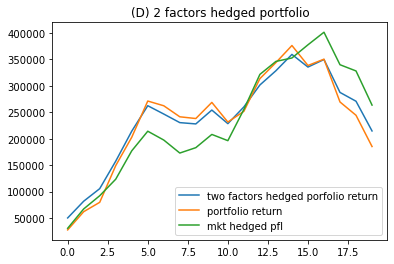

In [9]:
#plotting
plt.plot(np.add.accumulate(pfl_d_ret_cmb_hedged_array),label = 'two factors hedged porfolio return')
plt.plot(np.add.accumulate(pfl_d_ret_cmb_array),label = 'portfolio return')
plt.plot(partial_sum_dr_hedged_pfl_ret_array,label='mkt hedged pfl')
plt.legend()
plt.title('(D) 2 factors hedged portfolio')
plt.show()

(E) IR

In [10]:
#(A)
pfl_mkt_hedged_IR_float = np.mean(dr_hedged_pfl_ret_array)/np.std(dr_hedged_pfl_ret_array)*np.sqrt(252)
#(B,C)
stk1_IR_float = (np.mean(pfl_d_ret_array[:,0])- 0.5*np.mean(bmk_d_ret_array))/np.std(pfl_d_ret_array[:,0])*np.sqrt(252)
stk2_IR_float = (np.mean(pfl_d_ret_array[:,1])- 0.5*np.mean(bmk_d_ret_array))/np.std(pfl_d_ret_array[:,0])*np.sqrt(252)
stk1_hedged_IR_float = np.mean(stk1_d_ret_hedged_array)/np.std(stk1_d_ret_hedged_array)*np.sqrt(252)
stk2_hedged_IR_float = np.mean(stk2_d_ret_hedged_array)/np.std(stk2_d_ret_hedged_array)*np.sqrt(252)
#(D)
pfl_IR_float = np.mean(pfl_d_ret_cmb_array)/np.std(pfl_d_ret_cmb_array)*np.sqrt(252)
hedged_2factor_pfl_IR_float = np.mean(pfl_d_ret_cmb_hedged_array)/\
                      np.std(pfl_d_ret_cmb_hedged_array)*np.sqrt(252)

print(f"original portfolio IR: {pfl_IR_float}\n2 factors hedged portfolio IR: {hedged_2factor_pfl_IR_float}\n"
      f"mkt hedged portfolio IR: {pfl_mkt_hedged_IR_float}\nALB IR: {stk1_IR_float}\n"
      f"hedged ALB IR: {stk1_hedged_IR_float}\nXOM IR: {stk2_IR_float}\n"
      f"hedged XOM IR: {stk2_hedged_IR_float}")

original portfolio IR: 3.557290590357136
2 factors hedged portfolio IR: 4.884181760513085
mkt hedged portfolio IR: 6.016788516474001
ALB IR: 3.3005729846296568
hedged ALB IR: 4.269950519864246
XOM IR: 2.9898850743147976
hedged XOM IR: 4.3184952780324775


In most cases, hedged portfolio has a larger IR than that of an original portfolio as we expected.
However, single factor hedged portfolio has a larger IR compared with two-factor-hedged portfolio,
which may be a proof that adding factor blindly is not appropriate, which may even lower the effect of
hedging (lowering IR in this case). We should check the effectiveness of factors before adding them to
 the model.
